<a href="https://colab.research.google.com/github/promckkon/MK-DCNN/blob/main/MK-DCNN%20with%2030dB%20NOISE%20in%20TRIAX%20Dataset%20250625.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Dataset Input

In [40]:
df=pd.DataFrame(columns=['DE_data','fault']) # upload the dataset on googledrive

for root, dirs, files in os.walk("/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_NOISE_Dataset_30db", topdown=False):
    for file_name in files:
        path = os.path.join(root, file_name)
        print(path)

        mat = scipy.io.loadmat(path)

        key_name = list(mat.keys())[3]
        DE_data = mat.get(key_name)
        fault = np.full((len(DE_data), 1), file_name[:-4])

        df_temp = pd.DataFrame({'DE_data':np.ravel(DE_data) , 'fault':np.ravel(fault)})

        df = pd.concat([df,df_temp],axis=0)
        print(df['fault'].unique())

df.to_csv('/content/drive/MyDrive/MK DCNN TRIAX/NOISE_30_faults.csv',index=False)

/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_NOISE_Dataset_30db/Noise_Signal_inner_17.mat


/tmp/ipython-input-40-113101130.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df_temp],axis=0)


['Noise_Signal_inner_17']
/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_NOISE_Dataset_30db/Noise_Signal_inner_09.mat
['Noise_Signal_inner_17' 'Noise_Signal_inner_09']
/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_NOISE_Dataset_30db/Noise_Signal_Normal.mat
['Noise_Signal_inner_17' 'Noise_Signal_inner_09' 'Noise_Signal_Normal']
/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_NOISE_Dataset_30db/noise_signal_outer_17.mat
['Noise_Signal_inner_17' 'Noise_Signal_inner_09' 'Noise_Signal_Normal'
 'noise_signal_outer_17']
/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_NOISE_Dataset_30db/Noise_Signal_inner_07.mat
['Noise_Signal_inner_17' 'Noise_Signal_inner_09' 'Noise_Signal_Normal'
 'noise_signal_outer_17' 'Noise_Signal_inner_07']
/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_NOISE_Dataset_30db/noise_signal_outer_13.mat
['Noise_Signal_inner_17' 'Noise_Signal_inner_09' 'Noise_Signal_Normal'
 'noise_signal_outer_17' 'Noise_Signal_inner_07' 'noise_signal_outer_13']
/content/drive/MyDrive/TRIAX_with_NO

# Multi-Kernel Deep 1D-CNN

In [41]:
pip install tensorflow

In [42]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

win_len = int(average_samples_per_fault / approx_windows_per_fault)
stride = int(win_len * stride_ratio)

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [43]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, concatenate
from tensorflow.keras import backend as K

# --- Custom Physics-Informed Loss Function ---
def custom_loss(y_true, y_pred):
    # Standard categorical crossentropy
    loss = K.categorical_crossentropy(y_true, y_pred)

    # Physics-Informed Term: penalize rapid class probability changes
    # Ensure y_pred is at least 2D for slicing
    if K.ndim(y_pred) < 2:
        y_pred = K.expand_dims(y_pred, axis=-1)

    # Ensure y_pred has more than one class dimension to compute diff
    if K.int_shape(y_pred)[-1] > 1:
        diff = y_pred[:, 1:] - y_pred[:, :-1]
        squared_diff = tf.square(diff)
        physics_term = tf.reduce_mean(squared_diff)
    else:
        physics_term = 0.0 # No physics term if only one class


    # Total loss = classification loss + regularization term
    total_loss = loss + 0.01 * physics_term  # 0.01 is tunable

    return total_loss

# --- Model Definition ---
# no_classes = len(df['fault'].unique()) # Original line that caused 10 classes
no_classes = len(encoder.classes_) # Use the encoder to get the correct number of classes
print(f"Number of output classes (no_classes): {no_classes}") # Add print statement to verify

input_shape = (X.shape[1], X.shape[2])  # Example: (784, 1)

# Head 1
inputs1 = Input(shape=input_shape)
conv1 = Conv1D(filters=64, kernel_size=200, activation='relu')(inputs1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=20)(drop1)
flat1 = Flatten()(pool1)

# Head 2
inputs2 = Input(shape=input_shape)
conv2 = Conv1D(filters=64, kernel_size=100, activation='relu')(inputs2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=10)(drop2)
flat2 = Flatten()(pool2)

# Head 3
inputs3 = Input(shape=input_shape)
conv3 = Conv1D(filters=64, kernel_size=50, activation='relu')(inputs3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=5)(drop3)
flat3 = Flatten()(pool3)

# Merge all feature paths
merged = concatenate([flat1, flat2, flat3])

# Fully connected interpretation
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(no_classes, activation='softmax')(dense1)

# Build and compile model with custom loss
cnn_model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
cnn_model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# Model summary
cnn_model.summary()

Number of output classes (no_classes): 8


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 614, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 614, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 614, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 415, 64)   │     12,864 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 515, 64)   │      6,464 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 565, 64)   │      3,264 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 415, 64)   │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 515, 64)   │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 565, 64)   │          0 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 20, 64)    │          0 │ dropout_3[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 51, 64)    │          0 │ dropout_4[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 113, 64)   │          0 │ dropout_5[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 1280)      │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 3264)      │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 7232)      │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 11776)     │          0 │ flatten_3[0][0],  │
│ (Concatenate)       │                   │            │ flatten_4[0][0],  │
│                     │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100)       │  1,177,700 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │        808 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,201,100 (4.58 MB)

 Trainable params: 1,201,100 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
batch_size =100
epochs = 20
history = cnn_model.fit([X_train,X_train,X_train], y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=([X_test,X_test,X_test],y_test),shuffle=True)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.1372 - loss: 3.1786 - val_accuracy: 0.2062 - val_loss: 1.9740
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.2464 - loss: 1.8364 - val_accuracy: 0.3442 - val_loss: 1.6905
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 515ms/step - accuracy: 0.3911 - loss: 1.4853 - val_accuracy: 0.3961 - val_loss: 1.4746
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 374ms/step - accuracy: 0.5315 - loss: 1.2483 - val_accuracy: 0.4688 - val_loss: 1.3050
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 374ms/step - accuracy: 0.5994 - loss: 1.0835 - val_accuracy: 0.5341 - val_loss: 1.2090
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 437ms/step - accuracy: 0.6532 - loss: 0.9847 - val_accuracy: 0.4644 - val_loss: 1.2078
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 502ms/step - accuracy: 0.6644 - loss: 0.9355 - val_accuracy: 0.5697 - val_loss: 1.0915
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.6940 - loss: 0.8420 - val_accuracy: 0.

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


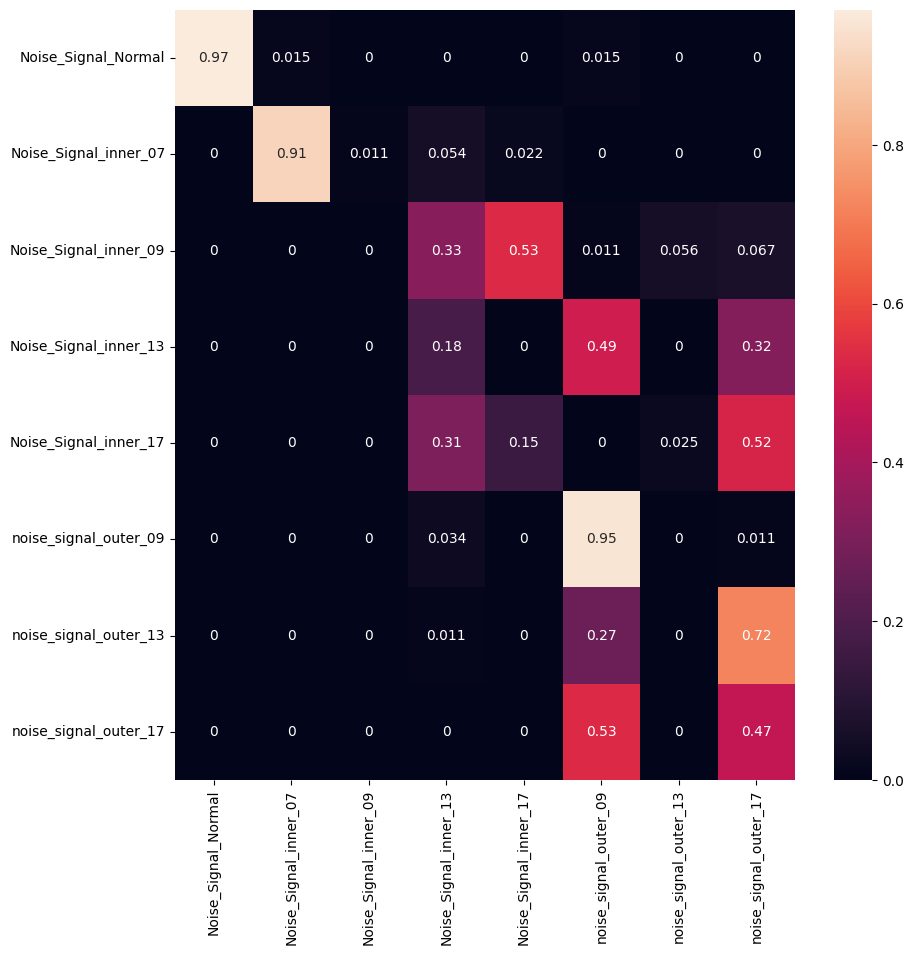

In [46]:
def inv_Transform_result(y_pred):
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict([X_test,X_test,X_test])


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)

In [47]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[16].output)
y_viz = dummy_cnn.predict([X_train,X_train,X_train])

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1572 samples in 0.001s...
[t-SNE] Computed neighbors for 1572 samples in 0.171s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1572
[t-SNE] Computed conditional probabilities for sample 1572 / 1572
[t-SNE] Mean sigma: 1.903160
[t-SNE] Computed conditional probabilities in 0.055s
[t-SNE] Iteration 50: error = 59.3800888, gradient norm = 0.0396220 (50 iterations in 0.746s)
[t-SNE] Iteration 100: error = 55.8306465, gradient norm = 0.0108396 (50 iterations in 0.558s)
[t-SNE] Iteration 150: error = 55.1668358, gradient norm = 0.0065151 (50 iterations in 0.540s)
[t-SNE] Iteration 200: error = 54.8566818, gradient norm = 0.0047265 (50 iterations in 0.550s)
[t-SNE] Iteration 250: error = 54.6707420, gradient norm = 0.0041817 (50 iterations in 0.528s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.670742
[t-SNE] Iteration 300: error = 1.0662297, gradient norm = 0.0165496 (50 iterations in 0.574s

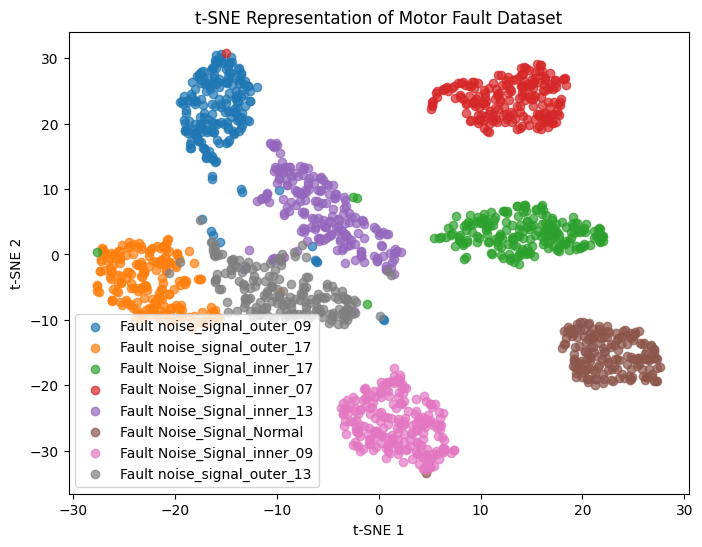

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE transformation
X_t_sne = TSNE(
    n_components=2,
    learning_rate='auto',
    verbose=2,  # Increase verbosity for more detailed feedback
    perplexity=40,
    n_iter=500  # Slightly increased number of iterations for convergence
).fit_transform(y_viz)

# Create DataFrame for t-SNE components
tSNEdf = pd.DataFrame(data=X_t_sne, columns=['T-SNE component 1', 'T-SNE component 2'])

# Assuming `inv_Transform_result` transforms `y_train` to get the Fault labels
tSNEdf['Fault'] = inv_Transform_result(y_train)

# Save the t-SNE DataFrame as a CSV file
tSNEdf.to_csv('/content/drive/MyDrive/MK DCNN TRIAX/NOISE_30_tSNE_results.csv', index=True)
print("t-SNE results saved as '/content/drive/MyDrive/MK DCNN TRIAX/NOISE_30_tSNE_results.csv'.")

# # Plot the t-SNE results with Fault as hue
# plt.figure(figsize=(12, 12))  # Larger figure for clarity
# sns.scatterplot(
#     x='T-SNE component 1',
#     y='T-SNE component 2',
#     hue='Fault',
#     palette=sns.color_palette("husl", as_cmap=False),  # Vivid color palette
#     data=tSNEdf,
#     legend="full",
#     alpha=0.7,  # Increased transparency for better overlap clarity
#     s=100  # Larger marker size
# )

# # Add gridlines for better visualization
# plt.grid


# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNEdf['Fault'].unique():
    subset = tSNEdf[tSNEdf['Fault'] == label]
    plt.scatter(subset['T-SNE component 1'], subset['T-SNE component 2'], label=f'Fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()

Statistical Features

In [49]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
import matplotlib.pyplot as plt

# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

WINDOW_SIZE = int(average_samples_per_fault / approx_windows_per_fault)
STRIDE = int(WINDOW_SIZE * stride_ratio)

print(f"Calculated WINDOW_SIZE: {WINDOW_SIZE}, STRIDE: {STRIDE}")

# Initialize a list to store statistical features
statistical_features = []

# Loop through each fault type
for f in df['fault'].unique():
    # Extract data for the current fault type
    fault_data = df[df['fault'] == f].iloc[:, 0].values  # Convert to NumPy array for efficiency

    # Compute windows using sliding window approach
    num_windows = (len(fault_data) - WINDOW_SIZE) // STRIDE + 1
    for i in range(num_windows):
        start = i * STRIDE
        end = start + WINDOW_SIZE
        window = fault_data[start:end]

        # Convert window to a numeric type
        window = window.astype(float)

        # Compute statistical features for the current window
        mean_val = np.mean(window)
        std_val = np.std(window)
        rms_val = np.sqrt(np.mean(np.square(window)))
        max_val = np.max(window)
        min_val = np.min(window)
        skewness_val = skew(window)
        kurtosis_val = kurtosis(window)

        # Additional statistical features
        mean_abs_val = np.mean(np.abs(window))
        form_factor = rms_val / mean_abs_val if mean_abs_val != 0 else 0
        crest_factor = max_val / rms_val if rms_val != 0 else 0

        # Store the features in a dictionary
        statistical_features.append({
            'fault': f,
            'window': i + 1,
            'mean': mean_val,
            'std': std_val,
            'rms': rms_val,
            'max': max_val,
            'min': min_val,
            'skewness': skewness_val,
            'kurtosis': kurtosis_val,
            'form_factor': form_factor,
            'crest_factor': crest_factor
        })

# Convert statistical features into a DataFrame
stat_features_df = pd.DataFrame(statistical_features)

# Display the extracted features and count of rows
print(f"Extracted {len(stat_features_df)} rows (target: {TARGET_ROWS})")
print(stat_features_df)

# Save the extracted features to a CSV file
output_file = "/content/drive/MyDrive/MK DCNN TRIAX/NOISE_30_statistical_features_with_form_and_crest_factors.csv"
stat_features_df.to_csv(output_file, index=False)
print(f"Statistical features saved to '{output_file}'.")

Calculated WINDOW_SIZE: 614, STRIDE: 491
Extracted 2246 rows (target: 1800)
                      fault  window      mean       std       rms       max  \
0     Noise_Signal_inner_17       1  0.218010  0.873426  0.900223  2.093916   
1     Noise_Signal_inner_17       2  0.210603  0.909794  0.933851  2.074510   
2     Noise_Signal_inner_17       3  0.203933  0.899694  0.922517  2.040228   
3     Noise_Signal_inner_17       4  0.191163  0.891178  0.911450  2.112496   
4     Noise_Signal_inner_17       5  0.208290  0.925396  0.948548  2.112496   
...                     ...     ...       ...       ...       ...       ...   
2241  noise_signal_outer_09     282  0.194202  0.856168  0.877917  2.080311   
2242  noise_signal_outer_09     283  0.191218  0.832763  0.854434  2.113445   
2243  noise_signal_outer_09     284  0.206227  0.836924  0.861957  2.068307   
2244  noise_signal_outer_09     285  0.216757  0.853420  0.880516  2.108465   
2245  noise_signal_outer_09     286  0.188382  0.820656

In [50]:
import pandas as pd
from sklearn.utils import resample

# Load your dataset (replace 'your_dataset.csv' with your actual file)
df = pd.read_csv('/content/drive/MyDrive/MK DCNN TRIAX/NOISE_30_statistical_features_with_form_and_crest_factors.csv')

# Display initial class distribution
print("Initial class distribution:")
print(df['fault'].value_counts())

# Target size for undersampling/resampling
TARGET_ROWS = 1570

# Separate all fault types
fault_classes = df['fault'].value_counts()

# Determine the number of classes
num_classes = len(fault_classes)

# Calculate how many samples to take from each class
samples_per_class = TARGET_ROWS // num_classes

# Initialize a list to store resampled data
resampled_data = []

# Loop over each class to resample them
for fault_class in fault_classes.index:
    class_data = df[df['fault'] == fault_class]
    if len(class_data) > samples_per_class:
        # Undersample
        class_data_resampled = resample(class_data, replace=False, n_samples=samples_per_class, random_state=42)
    else:
        # Upsample
        class_data_resampled = resample(class_data, replace=True, n_samples=samples_per_class, random_state=42)

    resampled_data.append(class_data_resampled)

# Concatenate the resampled data into a single DataFrame
balanced_df = pd.concat(resampled_data)

# Check if we have the exact number of rows
current_rows = len(balanced_df)
print(f"Current rows after equal resampling: {current_rows}")

# If the current rows don't match the target rows, adjust by trimming or adding rows
if current_rows > TARGET_ROWS:
    # Trim extra rows (if more than target)
    balanced_df = balanced_df.head(TARGET_ROWS)
elif current_rows < TARGET_ROWS:
    # Add rows if fewer than target, by sampling from existing data
    remaining_rows = TARGET_ROWS - current_rows
    additional_data = balanced_df.sample(n=remaining_rows, replace=True, random_state=42)
    balanced_df = pd.concat([balanced_df, additional_data])

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("New class distribution:")
print(balanced_df['fault'].value_counts())

# Display final row count
print(f"Final row count: {len(balanced_df)}")

# Save the balanced dataset to a CSV file
balanced_df.to_csv("/content/drive/MyDrive/MK DCNN TRIAX/NOISE_30_balanced_dataset_equal_resampling_exact_1570.csv", index=False)
print("Balanced dataset saved as '/content/drive/MyDrive/MK DCNN TRIAX/NOISE_30_balanced_dataset_equal_resampling_exact_1570.csv'")


Initial class distribution:
fault
Noise_Signal_inner_09    310
Noise_Signal_inner_07    291
Noise_Signal_inner_13    291
noise_signal_outer_09    286
Noise_Signal_inner_17    281
noise_signal_outer_17    277
noise_signal_outer_13    269
Noise_Signal_Normal      241
Name: count, dtype: int64
Current rows after equal resampling: 1568
New class distribution:
fault
Noise_Signal_Normal      197
noise_signal_outer_17    197
Noise_Signal_inner_13    196
Noise_Signal_inner_17    196
Noise_Signal_inner_09    196
Noise_Signal_inner_07    196
noise_signal_outer_09    196
noise_signal_outer_13    196
Name: count, dtype: int64
Final row count: 1570
Balanced dataset saved as '/content/drive/MyDrive/MK DCNN TRIAX/NOISE_30_balanced_dataset_equal_resampling_exact_1570.csv'


In [51]:
balanced_df.shape

(1570, 11)

In [52]:
balanced_df=balanced_df.sort_values(by='fault')

In [53]:
balanced_df

,fault,window,mean,std,rms,max,min,skewness,kurtosis,form_factor,crest_factor
0,Noise_Signal_Normal,160,0.098392,1.031513,1.036195,1.641277,-1.452305,0.031074,-1.482083,1.118018,1.583946
274,Noise_Signal_Normal,30,0.109844,1.048532,1.054270,1.678189,-1.493748,-0.014267,-1.470995,1.116622,1.591801
1495,Noise_Signal_Normal,239,0.128040,1.029330,1.037263,1.618513,-1.426301,-0.057970,-1.486354,1.116100,1.560368
1335,Noise_Signal_Normal,116,0.103759,1.031422,1.036628,1.643767,-1.470888,0.005928,-1.487605,1.113862,1.585686
261,Noise_Signal_Normal,191,0.117020,1.033079,1.039685,1.605282,-1.453439,-0.042994,-1.477266,1.116356,1.544008
...,...,...,...,...,...,...,...,...,...,...,...
443,noise_signal_outer_17,30,0.145584,0.743493,0.757613,2.022524,-1.564849,0.028323,-1.046062,1.163597,2.669602
1432,noise_signal_outer_17,259,0.186643,0.715607,0.739546,1.783257,-1.364686,0.029712,-0.991241,1.180511,2.411286
1001,noise_signal_outer_17,128,0.160175,0.722263,0.739811,1.844685,-1.511870,0.079413,-0.995332,1.175767,2.493454
1063,noise_signal_outer_17,202,0.175442,0.719098,0.740191,1.787195,-1.433111,0.019490,-1.018697,1.170175,2.414506


     t-SNE 1    t-SNE 2                fault
0 -28.844374 -26.850893  Noise_Signal_Normal
1 -41.904072 -22.130270  Noise_Signal_Normal
2 -37.286644 -24.354376  Noise_Signal_Normal
3 -23.707857 -28.914089  Noise_Signal_Normal
4 -23.684092 -27.900356  Noise_Signal_Normal


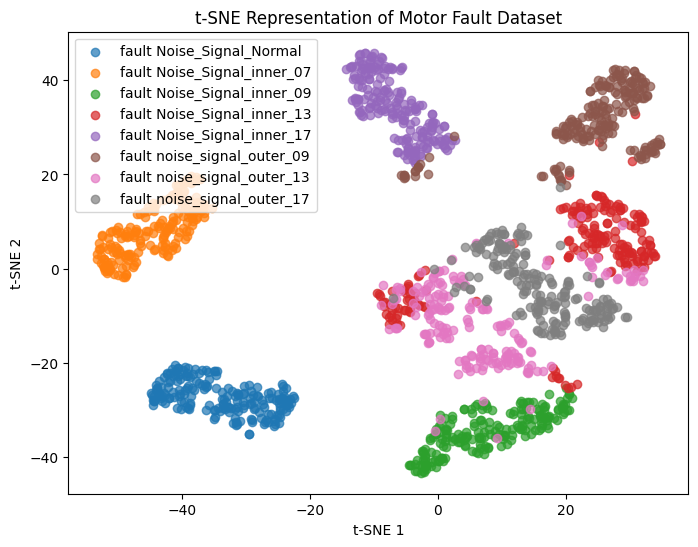

In [54]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Sort the dataset by the 'Fault' column
balanced_df = balanced_df.sort_values(by='fault')

# Separate features and target variable
X = balanced_df.drop(columns=['fault'])  # Replace 'Fault' with actual target column name
y = balanced_df['fault']

# Normalize the feature columns using StandardScaler
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Concatenate the normalized features with the target variable
STAT_Motor_Fault_dataset_normalized = pd.concat([X_normalized, y.reset_index(drop=True)], axis=1)

# Sort the normalized dataset by 'Fault' column
STAT_Motor_Fault_dataset_normalized = STAT_Motor_Fault_dataset_normalized.sort_values(by='fault')

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)  # 2D t-SNE
X_tsne = tsne.fit_transform(X_normalized)

# Create a DataFrame for t-SNE results
tSNE_representation = pd.DataFrame(X_tsne, columns=['t-SNE 1', 't-SNE 2'])
tSNE_representation['fault'] = y.reset_index(drop=True)

# Display the t-SNE representation
print(tSNE_representation.head())

# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNE_representation['fault'].unique():
    subset = tSNE_representation[tSNE_representation['fault'] == label]
    plt.scatter(subset['t-SNE 1'], subset['t-SNE 2'], label=f'fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


In [55]:
tSNE_representation

,t-SNE 1,t-SNE 2,fault
0,-28.844374,-26.850893,Noise_Signal_Normal
1,-41.904072,-22.130270,Noise_Signal_Normal
2,-37.286644,-24.354376,Noise_Signal_Normal
3,-23.707857,-28.914089,Noise_Signal_Normal
4,-23.684092,-27.900356,Noise_Signal_Normal
...,...,...,...
1565,18.056519,-11.074957,noise_signal_outer_17
1566,26.508474,-8.317286,noise_signal_outer_17
1567,15.916927,-10.970430,noise_signal_outer_17
1568,10.082721,1.046559,noise_signal_outer_17


In [56]:
tSNE_representation=tSNE_representation.drop(columns=['fault'])
tSNE_representation

,t-SNE 1,t-SNE 2
0,-28.844374,-26.850893
1,-41.904072,-22.130270
2,-37.286644,-24.354376
3,-23.707857,-28.914089
4,-23.684092,-27.900356
...,...,...
1565,18.056519,-11.074957
1566,26.508474,-8.317286
1567,15.916927,-10.970430
1568,10.082721,1.046559


In [57]:
tSNEdf = tSNEdf.sort_values(by='Fault')

In [58]:
tSNEdf

,T-SNE component 1,T-SNE component 2,Fault
295,19.513056,-10.626180,Noise_Signal_Normal
530,23.499701,-12.786230,Noise_Signal_Normal
125,20.246090,-14.836077,Noise_Signal_Normal
1405,22.280985,-15.809456,Noise_Signal_Normal
236,22.148499,-19.061258,Noise_Signal_Normal
...,...,...,...
250,-25.439518,-0.474017,noise_signal_outer_17
760,-20.898457,-2.430327,noise_signal_outer_17
1260,-23.214191,-3.494295,noise_signal_outer_17
815,-20.897409,-2.460355,noise_signal_outer_17


Combined Features

In [59]:
# import pandas as pd

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)
Motor_Fault_dataset=Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)

# Sort the dataset by 'Fault' column
Motor_Fault_dataset = Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset


,t-SNE 1,t-SNE 2,T-SNE component 1,T-SNE component 2,Fault
295,-51.298595,-0.290112,19.513056,-10.626180,Noise_Signal_Normal
530,11.692554,-30.941809,23.499701,-12.786230,Noise_Signal_Normal
125,-44.122810,-25.719917,20.246090,-14.836077,Noise_Signal_Normal
1405,26.590609,-10.690909,22.280985,-15.809456,Noise_Signal_Normal
236,-39.581047,13.056421,22.148499,-19.061258,Noise_Signal_Normal
...,...,...,...,...,...
250,-47.228046,1.378589,-25.439518,-0.474017,noise_signal_outer_17
760,23.932743,13.134342,-20.898457,-2.430327,noise_signal_outer_17
1260,-0.056622,-13.392458,-23.214191,-3.494295,noise_signal_outer_17
815,-9.448865,37.482555,-20.897409,-2.460355,noise_signal_outer_17


In [60]:
#Classification Report for MKDCNN

HSPSO-CatBoost


In [61]:
X = Motor_Fault_dataset.iloc[:, 0:4].values
y = Motor_Fault_dataset.iloc[:, 4].values

In [62]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [63]:
pip install hyperactive

In [64]:
pip install catboost

Deployment:

In [65]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier, Pool
from hyperactive import Hyperactive
from hyperactive.optimizers import ParticleSwarmOptimizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === DATA: Replace X_train, X_test, y_train, y_test with your actual data ===
# Example:
# X_train, X_test, y_train, y_test = train_test_split(...)

X, y = X_train, y_train

# === Objective Function ===
def model(opt):
    CatBoost = CatBoostClassifier(
        iterations=opt["iterations"],
        depth=opt["depth"],
        learning_rate=opt["learning_rate"],
        l2_leaf_reg=opt["l2_leaf_reg"],
        bagging_temperature=opt["bagging_temperature"],
        random_strength=opt["random_strength"],
        verbose=False
    )
    scores = cross_val_score(CatBoost, X, y, cv=4)
    return scores.mean()

# === Search Space ===
search_space = {
    "iterations": list(range(50, 501, 50)),
    "depth": list(range(1, 11)),
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5],
    "bagging_temperature": [0.5, 1, 1.5],
    "random_strength": [0.5, 1, 1.5],
}

# === Cauchy Mutation ===
def cauchy_mutation(particle, gamma=0.3):
    for key in particle:
        if isinstance(particle[key], (int, float)):
            particle[key] = particle[key] * (1 + gamma * np.tan(np.pi * (np.random.rand() - 0.5)))
            particle[key] = np.clip(particle[key], min(search_space[key]), max(search_space[key]))
            if isinstance(search_space[key][0], int):
                particle[key] = int(round(particle[key]))
    return particle

# === HSPSO Optimizer Class ===
class HybridStrategyPSO(ParticleSwarmOptimizer):
    def __init__(self, n_part=20, max_iter=40, **kwargs):
        super().__init__(**kwargs)
        self.switch_threshold = 10
        self.iteration = 0
        self.topology = "gbest"
        self.n_part = n_part
        self.max_iter = max_iter

        # Adaptive Inertia Parameters
        self.H = 1
        self.w_min = 0.4
        self.w_max = 0.9
        self.b = 0.9
        self.scaling_factor = 0.5

    def on_iteration(self, swarm, scores):
        self.iteration += 1

        # === Topology Switching ===
        if self.iteration % self.switch_threshold == 0:
            self.topology = "lbest" if self.topology == "gbest" else "gbest"
            self.set_topology(self.topology)

        # === Clone Best Particles ===
        best_indices = np.argsort(scores)[:max(1, len(swarm) // 5)]
        for idx in best_indices:
            particle = swarm[idx].copy()
            swarm.append(particle)
            scores.append(scores[idx])

        # === Prune Worst Particles ===
        if len(swarm) > 2 * self.n_part:
            worst_indices = np.argsort(scores)[-len(swarm)//4:]
            for i in reversed(worst_indices):
                del swarm[i]
                del scores[i]

        # === Nonlinear Adaptive Inertia ===
        numerator = (self.w_max - self.w_min) * self.iteration
        denominator = 1 + np.exp(-10 * self.b * ((2 * self.iteration) / (self.H * self.max_iter) - 1))
        self.inertia = self.w_max - numerator / denominator

        # === Cauchy Mutation ===
        for i in range(len(swarm)):
            if np.random.rand() < 0.2:
                swarm[i] = cauchy_mutation(swarm[i])

        # === Hook-Jeeves Local Search (simplified) ===
        top_ids = np.argsort(scores)[:2]
        for i in top_ids:
            particle = swarm[i]
            for key in particle:
                if isinstance(particle[key], (int, float)):
                    for delta in [-0.01, 0.01] if isinstance(particle[key], float) else [-1, 1]:
                        trial = particle.copy()
                        trial[key] = trial[key] + delta
                        trial[key] = np.clip(trial[key], min(search_space[key]), max(search_space[key]))
                        if isinstance(search_space[key][0], int):
                            trial[key] = int(round(trial[key]))
                        trial_score = model(trial)
                        if trial_score > scores[i]:
                            swarm[i] = trial
                            scores[i] = trial_score

        # === Random Restart ===
        if np.random.rand() < 0.1:
            random_idx = np.random.choice(len(swarm))
            for key in swarm[random_idx]:
                if isinstance(swarm[random_idx][key], (int, float)):
                    swarm[random_idx][key] = np.random.choice(search_space[key])

# === Run HSPSO Hyperparameter Tuning ===
start_time = datetime.now()

hyper = Hyperactive()

optimizer = HybridStrategyPSO(
    n_part=20,
    max_iter=40,
    inertia=0.5,
    cognitive_weight=0.9,
    social_weight=0.5,
    temp_weight=0.4,
    rand_rest_p=0.05,
)

hyper.add_search(model, search_space, optimizer=optimizer, n_iter=40)
hyper.run()

end_time = datetime.now()
print('Tuning Duration:', end_time - start_time)

# === Best Parameters ===
best_params = hyper.best_para(model)
print("Best Parameters:", best_params)

# === Train Final Model with Best Parameters ===
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

final_model = CatBoostClassifier(
    depth=best_params["depth"],
    iterations=best_params["iterations"],
    learning_rate=best_params["learning_rate"],
    l2_leaf_reg=best_params["l2_leaf_reg"],
    bagging_temperature=best_params["bagging_temperature"],
    random_strength=best_params["random_strength"],
    verbose=10
)

final_model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=best_params["iterations"] // 10,
    plot=True
)


[0] model (Particle Swarm Optimization): 100%|──────────| 40/40 [07:50<00:00, 11.77s/it, best_iter=0, best_pos=None, best_score=-inf]



Results: 'model'  
   Best score: 0.9745425133960166  
   Best parameter set:
      'iterations'          : 200.0  
      'depth'               : 7.0  
      'learning_rate'       : 0.05  
      'l2_leaf_reg'         : 3.0  
      'bagging_temperature' : 1.5  
      'random_strength'     : 1.0  
   Best iteration: 0  
 
   Random seed: 1160931832  
 
   Evaluation time   : 470.38611793518066 sec    [100.0 %]
   Optimization time : 0.013150691986083984 sec    [0.0 %]
   Iteration time    : 470.39926862716675 sec    [11.76 sec/iter]
 
Tuning Duration: 0:07:50.967699
Best Parameters: {'iterations': 200, 'depth': 7, 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'bagging_temperature': 1.5, 'random_strength': 1}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.8436609	test: 1.8438629	best: 1.8438629 (0)	total: 20.6ms	remaining: 4.1s
20:	learn: 0.5512892	test: 0.5555365	best: 0.5555365 (20)	total: 324ms	remaining: 2.76s
40:	learn: 0.2691043	test: 0.2747684	best: 0.2747684 (40)	total: 614ms	remaining: 2.38s
60:	learn: 0.1705298	test: 0.1802831	best: 0.1802831 (60)	total: 900ms	remaining: 2.05s
80:	learn: 0.1286880	test: 0.1430023	best: 0.1430023 (80)	total: 1.21s	remaining: 1.78s
100:	learn: 0.1081820	test: 0.1272967	best: 0.1272967 (100)	total: 1.51s	remaining: 1.48s
120:	learn: 0.0959573	test: 0.1183368	best: 0.1183368 (120)	total: 1.81s	remaining: 1.18s
140:	learn: 0.0866305	test: 0.1136639	best: 0.1136639 (140)	total: 2.15s	remaining: 900ms
160:	learn: 0.0783046	test: 0.1087184	best: 0.1087184 (160)	total: 2.44s	remaining: 592ms
180:	learn: 0.0729032	test: 0.1064707	best: 0.1064230 (179)	total: 2.73s	remaining: 286ms
199:	learn: 0.0678863	test: 0.1044541	best: 0.1043465 (198)	total: 2.99s	remaining: 0us

bestTest = 0.1043464878

In [66]:
hyper.add_search(model, search_space, optimizer=optimizer, n_iter=40, initialize={"random": 20})


In [67]:
learning_curve = final_model.get_evals_result()
print(learning_curve)

{'learn': {'MultiClass': [1.8436608947967452, 1.6549112216444777, 1.5040301977781059, 1.3813722875586645, 1.2874152912224233, 1.2057756538491877, 1.1267059596460136, 1.0564685624777828, 1.003610766536618, 0.9408422820078051, 0.8913803298776193, 0.8451523867755344, 0.8040015619724986, 0.7668359571602885, 0.730692532958969, 0.6928035032419175, 0.6615968858032075, 0.6326977162521689, 0.605626559500221, 0.5773928247057635, 0.5512892022744791, 0.5291183946542518, 0.5087760275377635, 0.4894776955517515, 0.4689620427878799, 0.4497227873520841, 0.43436726710382406, 0.4172398002407769, 0.40344259690628365, 0.3881022291418213, 0.37530943882135326, 0.3614847372057944, 0.3492312004512656, 0.33815030756477416, 0.32684402107516647, 0.31578366481201425, 0.30549744784532784, 0.29556738539263133, 0.28685599820162544, 0.277921305933045, 0.26910425337765964, 0.2631953804386804, 0.25612769320523554, 0.2499036760209625, 0.24307321967620324, 0.23614938234491334, 0.23005441744585, 0.22466451891960224, 0.2196

In [68]:
# Retrieve evaluation results
learning_curve = final_model.get_evals_result()

# Extract the metric values
# Assuming 'learn' corresponds to the training dataset
train_metric_values = learning_curve.get('learn', {}).get('MultiClass', [])

# Check the extracted values
if train_metric_values:
    print("Training metric values:", train_metric_values)
else:
    print("Metric 'MultiClass' not found in evaluation results.")


Training metric values: [1.8436608947967452, 1.6549112216444777, 1.5040301977781059, 1.3813722875586645, 1.2874152912224233, 1.2057756538491877, 1.1267059596460136, 1.0564685624777828, 1.003610766536618, 0.9408422820078051, 0.8913803298776193, 0.8451523867755344, 0.8040015619724986, 0.7668359571602885, 0.730692532958969, 0.6928035032419175, 0.6615968858032075, 0.6326977162521689, 0.605626559500221, 0.5773928247057635, 0.5512892022744791, 0.5291183946542518, 0.5087760275377635, 0.4894776955517515, 0.4689620427878799, 0.4497227873520841, 0.43436726710382406, 0.4172398002407769, 0.40344259690628365, 0.3881022291418213, 0.37530943882135326, 0.3614847372057944, 0.3492312004512656, 0.33815030756477416, 0.32684402107516647, 0.31578366481201425, 0.30549744784532784, 0.29556738539263133, 0.28685599820162544, 0.277921305933045, 0.26910425337765964, 0.2631953804386804, 0.25612769320523554, 0.2499036760209625, 0.24307321967620324, 0.23614938234491334, 0.23005441744585, 0.22466451891960224, 0.21964

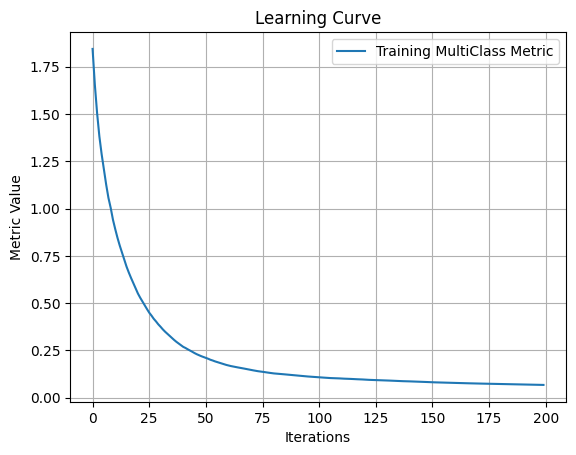

In [69]:
import matplotlib.pyplot as plt

# Plotting the learning curve
plt.plot(train_metric_values, label='Training MultiClass Metric')
plt.xlabel('Iterations')
plt.ylabel('Metric Value')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()


Classification Report - Training Set:
                       precision    recall  f1-score   support

  Noise_Signal_Normal       1.00      0.99      1.00       143
Noise_Signal_inner_07       1.00      0.99      1.00       164
Noise_Signal_inner_09       0.99      1.00      1.00       173
Noise_Signal_inner_13       0.95      0.98      0.97       159
Noise_Signal_inner_17       1.00      0.98      0.99       152
noise_signal_outer_09       0.99      0.96      0.98       156
noise_signal_outer_13       0.96      0.97      0.97       150
noise_signal_outer_17       0.98      0.99      0.99       160

             accuracy                           0.98      1257
            macro avg       0.99      0.98      0.98      1257
         weighted avg       0.99      0.98      0.98      1257

Classification Report - Test Set:
                       precision    recall  f1-score   support

  Noise_Signal_Normal       1.00      1.00      1.00        31
Noise_Signal_inner_07       1.00      1.00

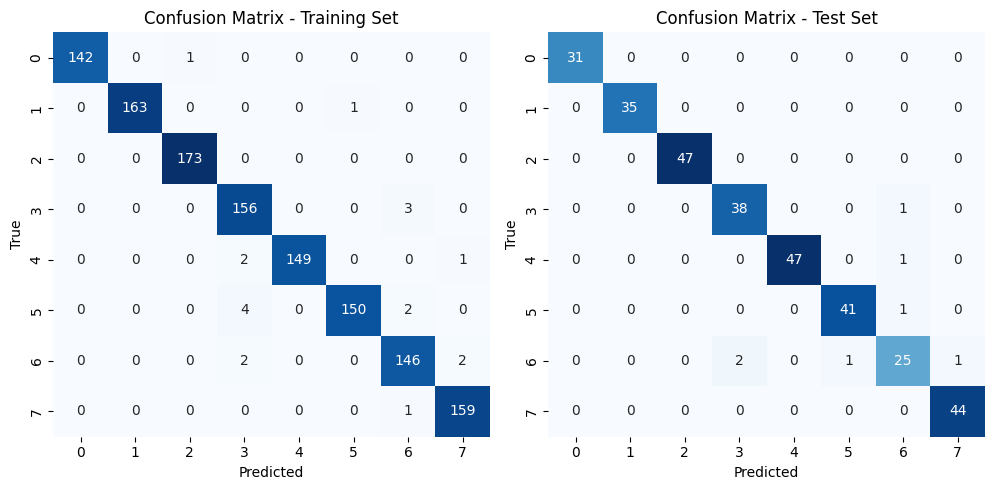

Deployment Duration: 0:07:56.159381


In [70]:
# Predictions
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.savefig('C-Matrix.svg', format='svg')
plt.show()

end_time = datetime.now()
print('Deployment Duration: {}'.format(end_time - start_time))

In [71]:
final_model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Evaluate train accuracy
result_train = final_model.score(X_train, y_train)
print("Train Accuracy : {}".format(result_train))

# Evaluate test accuracy
result_test = final_model.score(X_test, y_test)
print("Test Accuracy : {}".format(result_test))

# Predictions
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# Classification report
print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

0:	learn: 1.8436609	test: 1.8438629	best: 1.8438629 (0)	total: 14.1ms	remaining: 2.81s
10:	learn: 0.8913803	test: 0.8947009	best: 0.8947009 (10)	total: 243ms	remaining: 4.17s
20:	learn: 0.5512892	test: 0.5555365	best: 0.5555365 (20)	total: 612ms	remaining: 5.22s
30:	learn: 0.3753094	test: 0.3794830	best: 0.3794830 (30)	total: 1.03s	remaining: 5.62s
40:	learn: 0.2691043	test: 0.2747684	best: 0.2747684 (40)	total: 1.36s	remaining: 5.26s
50:	learn: 0.2109557	test: 0.2191331	best: 0.2191331 (50)	total: 1.75s	remaining: 5.1s
60:	learn: 0.1705298	test: 0.1802831	best: 0.1802831 (60)	total: 2.07s	remaining: 4.72s
70:	learn: 0.1467970	test: 0.1591209	best: 0.1591209 (70)	total: 2.58s	remaining: 4.69s
80:	learn: 0.1286880	test: 0.1430023	best: 0.1430023 (80)	total: 3.31s	remaining: 4.87s
90:	learn: 0.1180886	test: 0.1350468	best: 0.1350468 (90)	total: 4.29s	remaining: 5.14s
100:	learn: 0.1081820	test: 0.1272967	best: 0.1272967 (100)	total: 5.21s	remaining: 5.11s
110:	learn: 0.1013993	test: 0.12